## End of the distribution imputation

On occasions, one has reasons to suspect that missing values are not missing at random. And if the value is missing, there has to be a reason for it. Therefore, we would like to capture this information.

Adding an additional variable indicating missingness may help with this task (as we discussed in the previous lecture). However, the values are still missing in the original variable, and they need to be replaced if we plan to use the variable in machine learning.

Sometimes, we may also not want to increase the feature space by adding a variable to capture missingness.

So what can we do instead?

We can replace the NA, by values that are at the far end of the distribution of the variable.

**The rationale is that if the value is missing, it has to be for a reason, therefore, we would not like to replace missing values for the mean and make that observation look like the majority of our observations.** Instead, we want to flag that observation as different, and therefore we assign a value that is at the tail of the distribution, where observations are rarely represented in the population.

### Advantages

- Easy to implement
- Captures the importance of missingess if there is one

### Disadvantages

- Distorts the original distribution of the variable
- If missingess is not important, it may mask the predictive power of the original variable by distorting its distribution
- If the number of NA is big, it will mask true outliers in the distribution
- If the number of NA  is small, the replaced NA may be considered an outlier and pre-processed in a subsequent step of feature engineering


### Final note

I haven't seen this method used in data competitions, however, this method is used in finance companies. When capturing the financial history of customers, if some of the variables are missing, the company does not like to assume that missingness is random. Therefore, a different treatment is provided to replace them, by placing them at the end of the distribution.

See my talk at pydata London for an example of feature engineering in Finance:
https://www.youtube.com/watch?v=KHGGlozsRtA

===============================================================================

## Real Life example: 

### Predicting Survival on the Titanic: understanding society behaviour and beliefs

Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.


### Predicting Sale Price of Houses

The problem at hand aims to predict the final sale price of homes based on different explanatory variables describing aspects of residential homes. Predicting house prices is useful to identify fruitful investments, or to determine whether the price advertised for a house is over or underestimated, before making a buying judgment.

=============================================================================

In the following cells, I will show how this procedure impacts features and machine learning using the Titanic and House Price datasets from Kaggle.

If you haven't downloaded the datasets yet, in the lecture "Guide to setting up your computer" in section 1, you can find the details on how to do so.

In [25]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# for regression problems
from sklearn.linear_model import LinearRegression, Ridge

# for classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# to split and standarize the datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# to evaluate regression models
from sklearn.metrics import mean_squared_error

# to evaluate classification models
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [26]:
%cd ../data_set/
# load the Titanic Dataset with a few variables for demonstration

data = pd.read_csv('titanic.csv', usecols = ['Age', 'Fare','Survived'])
data.head()

/home/pat/Desktop/Udemy_FeatureEngineering/data_set


,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [27]:
# let's look at the percentage of NA
data.isnull().mean()

Survived    0.000000
Age         0.198653
Fare        0.000000
dtype: float64

### Imputation important

Imputation has to be done over the training set, and then propagated to the test set. This means that when replacing by a value at the far end of the distribution, it has to be the distribution of the variable in the training set the one that we will use to replace NA both in train and test set.

In [28]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data, data.Survived, test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((623, 3), (268, 3))

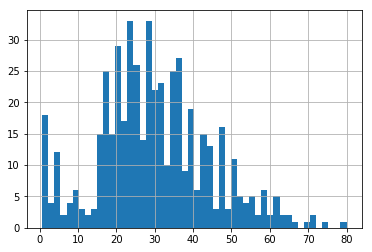

In [29]:
X_train.Age.hist(bins=50)

In [30]:
# far end of the distribution
X_train.Age.mean()+3*X_train.Age.std()

73.43632005918369

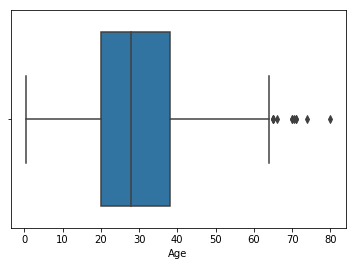

In [31]:
# we see that there are a few outliers for Age, according to its distribution
# these outliers will be masked when we replace NA by values at the far end 
# see below

sns.boxplot('Age', data=data)

In [32]:
def impute_na(df, variable, median, extreme):
    df[variable+'_far_end'] = df[variable].fillna(extreme)
    df[variable].fillna(median, inplace=True)

In [33]:
# let's replace the NA with the median value in the training and testing sets
impute_na(X_train, 'Age', X_train.Age.median(), X_train.Age.mean()+3*X_train.Age.std())
impute_na(X_test, 'Age', X_train.Age.median(), X_train.Age.mean()+3*X_train.Age.std())

X_train.head(20)

,Survived,Age,Fare,Age_far_end
857,1,51.0,26.5500,51.00000
52,1,49.0,76.7292,49.00000
386,0,1.0,46.9000,1.00000
124,0,54.0,77.2875,54.00000
578,0,29.0,14.4583,73.43632
549,1,8.0,36.7500,8.00000
118,0,24.0,247.5208,24.00000
12,0,20.0,8.0500,20.00000
157,0,30.0,8.0500,30.00000
127,1,24.0,7.1417,24.00000


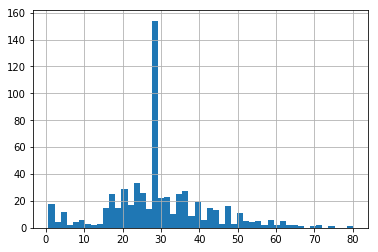

In [34]:
# we see an accumulation of values around the median for the median imputation
X_train.Age.hist(bins=50)

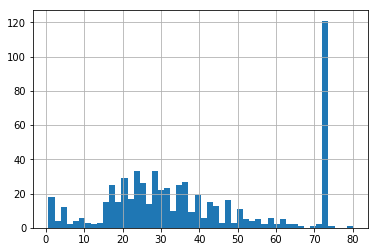

In [35]:
# we see an accumulation of values at the far end for the far end imputation

X_train.Age_far_end.hist(bins=50)

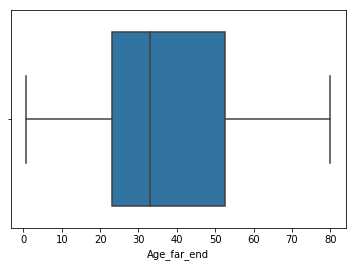

In [36]:
# indeed, far end imputation now indicates that there are no outliers in the variable
sns.boxplot('Age_far_end', data=X_train)

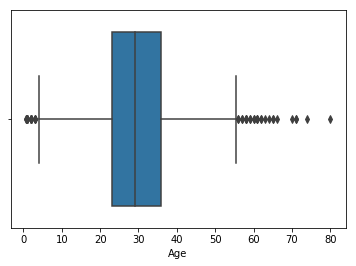

In [37]:
# on the other hand, replacing values by the median, now generates the impression of a higher
# amount of outliers

sns.boxplot('Age', data=X_train)

### Logistic Regression

In [38]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

X_train.columns = ['Survived','Age','Fare','Age_far_end']
X_test.columns = ['Survived','Age','Fare','Age_far_end']

In [39]:
# we compare the models built using Age filled with median, vs Age filled with values at the far end of the distribution
# variable indicating missingness

logit = LogisticRegression(random_state=44, C=1000) # c big to avoid regularization
logit.fit(X_train[['Age','Fare']], y_train)
print('Train set')
pred = logit.predict_proba(X_train[['Age','Fare']])
print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
print('Test set')
pred = logit.predict_proba(X_test[['Age','Fare']])
print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

logit = LogisticRegression(random_state=44, C=1000) # c big to avoid regularization
logit.fit(X_train[['Age_far_end','Fare']], y_train)
print('Train set')
pred = logit.predict_proba(X_train[['Age_far_end','Fare']])
print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
print('Test set')
pred = logit.predict_proba(X_test[['Age_far_end','Fare']])
print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

Train set
Logistic Regression roc-auc: 0.6794863451985858
Test set
Logistic Regression roc-auc: 0.7244940476190477
Train set
Logistic Regression roc-auc: 0.6781577406130018
Test set
Logistic Regression roc-auc: 0.7197619047619047


### Support Vector Machine

In [40]:
# we compare the models built using Age filled with median, vs Age filled with values at the far end of the distribution
# variable indicating missingness

SVM_model = SVC(random_state=44, probability=True, max_iter=-1, kernel='linear')
SVM_model.fit(X_train[['Age', 'Fare']], y_train)
print('Train set')
pred = SVM_model.predict_proba(X_train[['Age', 'Fare']])
print('SVC roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
print('Test set')
pred = SVM_model.predict_proba(X_test[['Age', 'Fare']])
print('SVC roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

# model build using natural distributions

SVM_model = SVC(random_state=44, probability=True, max_iter=-1, kernel='linear')
SVM_model.fit(X_train[['Age_far_end','Fare']], y_train)
print('Train set')
pred = SVM_model.predict_proba(X_train[['Age_far_end','Fare']])
print('SVC roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
print('Test set')
pred = SVM_model.predict_proba(X_test[['Age_far_end','Fare']])
print('SVC roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

Train set
SVC roc-auc: 0.6931086093577146
Test set
SVC roc-auc: 0.7418154761904762
Train set
SVC roc-auc: 0.6816175354113793
Test set
SVC roc-auc: 0.7411904761904761


In the titanic dataset, replacing missing values in Age with the median obtains better results.

### House Sale Dataset

In [41]:
# we are going to train a model on the following variables,

cols_to_use = ['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea','WoodDeckSF', 'BsmtUnfSF',
               'LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [42]:
# let's load the House Sale Price dataset

data = pd.read_csv('houseprice.csv', usecols=cols_to_use+['SalePrice'])
print(data.shape)
data.head()

(1460, 10)


,LotFrontage,OverallQual,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,WoodDeckSF,SalePrice
0,65.0,7,196.0,150,856,856,1710,2003.0,0,208500
1,80.0,6,0.0,284,1262,1262,1262,1976.0,298,181500
2,68.0,7,162.0,434,920,920,1786,2001.0,0,223500
3,60.0,7,0.0,540,756,961,1717,1998.0,0,140000
4,84.0,8,350.0,490,1145,1145,2198,2000.0,192,250000


In [43]:
# let's inspect the columns with missing values
data.isnull().mean()

LotFrontage    0.177397
OverallQual    0.000000
MasVnrArea     0.005479
BsmtUnfSF      0.000000
TotalBsmtSF    0.000000
1stFlrSF       0.000000
GrLivArea      0.000000
GarageYrBlt    0.055479
WoodDeckSF     0.000000
SalePrice      0.000000
dtype: float64

In [44]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data, data.SalePrice, test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((1022, 10), (438, 10))

In [45]:
# let's look at the median of the variables with NA

X_train[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].median()

LotFrontage      69.0
MasVnrArea        0.0
GarageYrBlt    1979.0
dtype: float64

In [46]:
# let's impute the NA with the median
# remember that we need to impute with the median for the train set, and then propagate to test set

median = X_train.LotFrontage.median()
extreme = X_train.LotFrontage.mean()+3*X_train.LotFrontage.std()
impute_na(X_train, 'LotFrontage', median, extreme)
impute_na(X_test, 'LotFrontage', median, extreme)

In [47]:
median = X_train.MasVnrArea.median()
extreme = X_train.MasVnrArea.mean()+3*X_train.MasVnrArea.std()
impute_na(X_train, 'MasVnrArea', median, extreme)
impute_na(X_test, 'MasVnrArea', median, extreme)

In [48]:
median = X_train.GarageYrBlt.median()
extreme = X_train.GarageYrBlt.mean()+3*X_train.GarageYrBlt.std()
impute_na(X_train, 'GarageYrBlt', median, extreme)
impute_na(X_test, 'GarageYrBlt', median, extreme)

In [49]:
X_train.isnull().mean()

LotFrontage            0.0
OverallQual            0.0
MasVnrArea             0.0
BsmtUnfSF              0.0
TotalBsmtSF            0.0
1stFlrSF               0.0
GrLivArea              0.0
GarageYrBlt            0.0
WoodDeckSF             0.0
SalePrice              0.0
LotFrontage_far_end    0.0
MasVnrArea_far_end     0.0
GarageYrBlt_far_end    0.0
dtype: float64

In [50]:
# create a list with the untransformed columns
cols_to_use_median = X_train.columns[:-4]
cols_to_use_median

Index(['LotFrontage', 'OverallQual', 'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', 'GrLivArea', 'GarageYrBlt', 'WoodDeckSF'],
      dtype='object')

In [51]:
cols_to_use_extreme = list(X_train.columns)
cols_to_use_extreme = [col for col in cols_to_use_extreme if col not in ['LotFrontage',
                                                         'MasVnrArea',
                                                        'GarageYrBlt',
                                                        'SalePrice']]
cols_to_use_extreme

['OverallQual',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'WoodDeckSF',
 'LotFrontage_far_end',
 'MasVnrArea_far_end',
 'GarageYrBlt_far_end']

In [52]:
# let's standarise the dataset
scaler = StandardScaler()
X_train_median = scaler.fit_transform(X_train[cols_to_use_median])
X_test_median = scaler.transform(X_test[cols_to_use_median])

scaler = StandardScaler()
X_train_extreme = scaler.fit_transform(X_train[cols_to_use_extreme])
X_test_extreme = scaler.transform(X_test[cols_to_use_extreme])

### Linear Regression

In [53]:
linreg = LinearRegression()
linreg.fit(X_train_median, y_train)
print('Train set')
pred = linreg.predict(X_train_median)
print('Linear Regression mse: {}'.format(mean_squared_error(y_train, pred)))
print('Test set')
pred = linreg.predict(X_test_median)
print('Linear Regression mse: {}'.format(mean_squared_error(y_test, pred)))
print()
linreg = LinearRegression()
linreg.fit(X_train_extreme, y_train)
print('Train set')
pred = linreg.predict(X_train_extreme)
print('Linear Regression mse: {}'.format(mean_squared_error(y_train, pred)))
print('Test set')
pred = linreg.predict(X_test_extreme)
print('Linear Regression mse: {}'.format(mean_squared_error(y_test, pred)))
print()

Train set
Linear Regression mse: 1161895545.4832032
Test set
Linear Regression mse: 2212393764.7463074

Train set
Linear Regression mse: 1216146367.507596
Test set
Linear Regression mse: 2161266505.3352323



In [54]:
round(2212393764.7463093-2161266505.3352327,0)

51127259.0

Here, replacing NA by a value at the end of the distribution, resulted in a lower mean squared error. These means that the difference between the real value and the estimated value is smaller, and thus our model performs better.

There is a difference of ~50 million between the model that replaces with the median and the one that uses the far end distribution. So the overall value may seem similar, but when we boil it down to business value, the impact is massive.

In [55]:
# same as above but using a regularised linear regression
linreg = Ridge(random_state=30, max_iter=5, tol=100, alpha=10)
linreg.fit(X_train_median, y_train)
print('Train set')
pred = linreg.predict(X_train_median)
print('Ridge Regression mse: {}'.format(mean_squared_error(y_train, pred)))
print('Test set')
pred = linreg.predict(X_test_median)
print('Ridge Regression mse: {}'.format(mean_squared_error(y_test, pred)))
print()

linreg = Ridge(random_state=30, max_iter=5, tol=100, alpha=10)
linreg.fit(X_train_extreme, y_train)
print('Train set')
pred = linreg.predict(X_train_extreme)
print('Ridge Regression mse: {}'.format(mean_squared_error(y_train, pred)))
print('Test set')
pred = linreg.predict(X_test_extreme)
print('Ridge Regression mse: {}'.format(mean_squared_error(y_test, pred)))
print()

Train set
Ridge Regression mse: 1162112961.4104362
Test set
Ridge Regression mse: 2203311969.1879954

Train set
Ridge Regression mse: 1216375050.7253299
Test set
Ridge Regression mse: 2153551540.440346



In [56]:
round(2203311969.187996-2153551540.4403453,0)

49760429.0

Same conclusion for regularised linear regression. Go ahead and investigate the impact of this variable replacement on the outliers, if there were any.

**That is all for this demonstration. I hope you enjoyed the notebook, and see you in the next one.**